# CS 4641 Midterm Checkpoint

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.svm import SVC

In [5]:
df = pd.read_csv('data/games.csv')
print(df.shape)

(20058, 16)


---

## Preprocessing

Manual Dimensionality Reduction to remove features that definitely won't be helpful for prediction.

In [6]:
df.drop(['id', 'turns', 'victory_status', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
df.head()

,rated,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


**Feature Encoding:** Encode non-numerical features

In [7]:
print(df['increment_code'].nunique())
print(df['opening_eco'].nunique())
print(df['opening_name'].nunique())
print(df['moves'].nunique())

400
365
1477
18920


In [8]:
# If we want just the first part of opening_name
df['opening_name'] = df['opening_name'].str.split(':').str[0]

# Split moves into list of strings
df['moves'] = df['moves'].str.split(' ')


In [11]:
print(df['winner'].unique())

print((df['winner'] == 'draw').sum())

# If we want it to be binary classification (slightly more accurate): just drop since its a small number?
# df = df[df['winner'] != 'draw']

[2 0 1]
0


In [13]:
# Use label encoder for opening_name, increment_code, opening_eco
le_opening = preprocessing.LabelEncoder()
df['opening_name'] = le_opening.fit_transform(df['opening_name'])
le_winner = preprocessing.LabelEncoder()
df['winner'] = le_winner.fit_transform(df['winner'])
# le_victory = preprocessing.LabelEncoder()
# df['victory_status'] = le_victory.fit_transform(df['victory_status'])
le_eco = preprocessing.LabelEncoder()
df['opening_eco'] = le_eco.fit_transform(df['opening_eco'])
le_increment = preprocessing.LabelEncoder()
df['increment_code'] = le_increment.fit_transform(df['increment_code'])

# For now, dropping moves so I can see if things work
#   Idea: determine frequency of each value in opening_ply, then if one value is very common just use the first x moves for each entry.
#       Or just find the max value in opening_ply, so each one is kept.
#       One new column for each move, then encode them with labelencoder.
df.drop(['moves'], axis=1, inplace=True)

df.head()

KeyError: "['moves'] not found in axis"

**Dimensionality Reduction with PCA:**

In [14]:
# Apply PCA to the current dataset. Store PCA-reduced df separately so we can compare how both perform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features except winner for PCA
features = df.drop(['winner'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)

# Create a DataFrame with PCA components and winner
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_pca['winner'] = df['winner'].values

# Display the PCA-reduced DataFrame and its new shape
print(df_pca.head())
print(f'Original shape: {df.shape}, PCA-reduced shape: {df_pca.shape}')

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.471857  1.709296 -1.669903  0.910212 -1.143104 -0.532847  0.642541   
1 -1.630621 -0.033435 -0.500996 -0.016191  1.318174  0.644403  0.139551   
2 -0.657048 -0.033183 -0.531737 -0.271159  1.340606 -0.598795 -0.066227   
3 -0.462698  0.987005 -0.070120  0.478803  0.910885 -1.013985 -0.085342   
4 -0.154381  0.602989 -0.395361  0.071365  1.157095 -0.200766  0.085027   

   winner  
0       2  
1       0  
2       2  
3       2  
4       2  
Original shape: (20058, 8), PCA-reduced shape: (20058, 8)


In [16]:
# Display the explained variance ratios
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%}")

# Show cumulative variance
cumulative_variance = np.cumsum(explained_variance)
for i, variance in enumerate(cumulative_variance):
    print(f"Up to Principal Component {i+1}: {variance:.2%}")

Principal Component 1: 27.22%
Principal Component 2: 18.35%
Principal Component 3: 15.33%
Principal Component 4: 14.10%
Principal Component 5: 13.04%
Principal Component 6: 6.75%
Principal Component 7: 5.20%
Up to Principal Component 1: 27.22%
Up to Principal Component 2: 45.58%
Up to Principal Component 3: 60.91%
Up to Principal Component 4: 75.01%
Up to Principal Component 5: 88.05%
Up to Principal Component 6: 94.80%
Up to Principal Component 7: 100.00%


---

## Machine Learning Model

In [11]:
X = df.drop('winner', axis=1)
y = df['winner']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [13]:
model = RandomForestClassifier()

kfolds = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train, cv=kfolds)
print("Accuracy at each fold: " + str(scores))
print("Mean Accuracy: " + str(scores.mean()))

Accuracy at each fold: [0.63364486 0.62180685 0.62616822 0.63800623 0.62367601 0.61744548
 0.63216958 0.63840399 0.6340399  0.62094763]
Mean Accuracy: 0.628630876080826


Fit a Random Forest Classifier without specifying hyperparameters:

In [14]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Find and use best hyperparameters using Grid Search:

In [228]:
# To Do (Maybe)
# Reference: https://dev.to/anurag629/gridsearchcv-in-scikit-learn-a-comprehensive-guide-2a72 
# (Except need to use hyperparameters from Random Forest: n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf, maybe others...)

## Evaluation Metrics:

In [15]:
train_accuracy = clf.score(X_train, y_train)
print("Train Score: " + str(train_accuracy))
test_accuracy = clf.score(X_test, y_test)
print("Test Score: " + str(test_accuracy))

y_pred = clf.predict(X_test)

Train Score:0.9991898292409324
Test Score:0.6241276171485544


**Confusion Matrix:** 

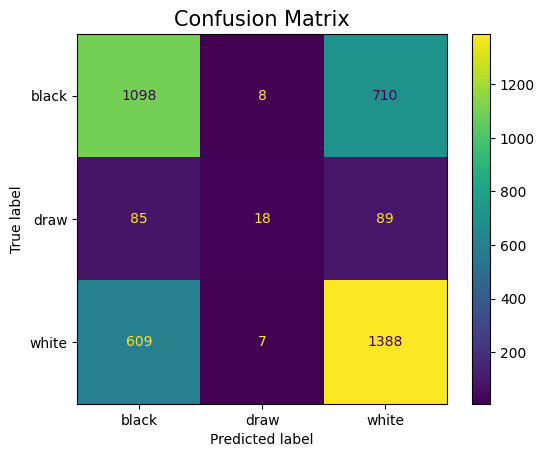

In [16]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['black', 'draw', 'white'])
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()